Original Shape: (62269, 16)
After PCA Shape: (62269, 11)

Silhouette Scores:
K=2, Score=0.2730
K=3, Score=0.2749
K=4, Score=0.1520
K=5, Score=0.1684
K=6, Score=0.1736
K=7, Score=0.1797
K=8, Score=0.1820

Optimal K Selected: 3


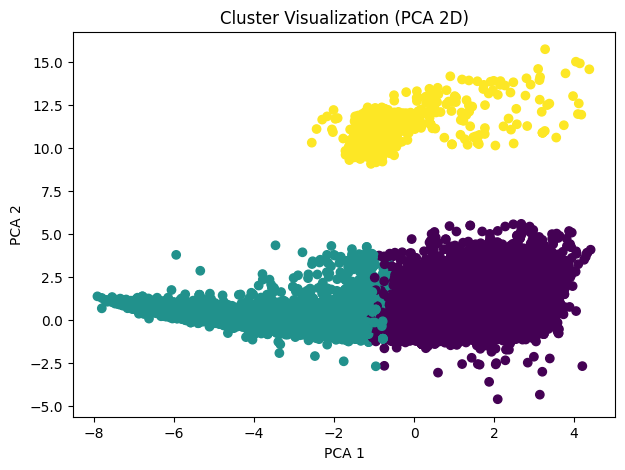


Cluster Acoustic Profile:
         acousticness  danceability    energy  instrumentalness  speechiness  \
Cluster                                                                        
0            0.239041      0.664783  0.715016          0.062574     0.091848   
1            0.689292      0.414019  0.319257          0.379261     0.047449   
2            0.544219      0.677360  0.203451          0.005854     0.862477   

          valence       tempo   loudness  
Cluster                                   
0        0.591183  120.329916  -6.873753  
1        0.243306  111.953104 -14.122277  
2        0.416573  112.561601 -18.643999  

Average Popularity per Cluster:
Cluster
0    16.620919
1    12.530071
2     2.007386
Name: popularity, dtype: float64

Median Popularity per Cluster:
Cluster
0    8.0
1    5.0
2    0.0
Name: popularity, dtype: float64

Language Distribution per Cluster:
language   English     Hindi    Korean  Malayalam     Tamil    Telugu  \
Cluster                      

In [1]:
# ==========================================
# 1. IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


# ==========================================
# 2. LOAD DATA
# ==========================================
df = pd.read_csv("spotify_tracks.csv")
df_original = df.copy()


# ==========================================
# 3. CLEAN DATA
# ==========================================
df.drop(columns=[
    "track_id",
    "track_name",
    "artist_name",
    "album_name",
    "artwork_url",
    "track_url"
], inplace=True)

df = df[(df["loudness"] > -60) & (df["loudness"] <= 0)]
df = df.dropna()


# ==========================================
# 4. FEATURE ENGINEERING (OPTIMIZED)
# ==========================================

# Duration in minutes
df["duration_min"] = df["duration_ms"] / 60000

# Interaction Features (High signal)
df["energy_loudness"] = df["energy"] * df["loudness"]
df["dance_valence"] = df["danceability"] * df["valence"]
df["speech_energy"] = df["speechiness"] * df["energy"]

# Mode transformation
df["minor_mode"] = 1 - df["mode"]

# Binary intensity indicators
df["high_acoustic"] = (df["acousticness"] > 0.7).astype(int)
df["high_speech"] = (df["speechiness"] > 0.6).astype(int)


# ==========================================
# 5. FEATURE SELECTION (NO NOISE)
# ==========================================

features = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "valence",
    "duration_min",

    # Engineered
    "energy_loudness",
    "dance_valence",
    "speech_energy",
    "minor_mode",
    "high_acoustic",
    "high_speech"
]

X = df[features]


# ==========================================
# 6. SCALE FEATURES
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ==========================================
# 7. PCA
# ==========================================
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Original Shape:", X_scaled.shape)
print("After PCA Shape:", X_pca.shape)


# ==========================================
# 8. FIND OPTIMAL K
# ==========================================
sil_scores = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    sil_scores.append(score)

print("\nSilhouette Scores:")
for k, score in zip(K_range, sil_scores):
    print(f"K={k}, Score={score:.4f}")

optimal_k = K_range[np.argmax(sil_scores)]
print(f"\nOptimal K Selected: {optimal_k}")


# ==========================================
# 9. FINAL MODEL
# ==========================================
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

df_original = df_original.loc[df.index]
df_original["Cluster"] = clusters


# ==========================================
# 10. PCA VISUALIZATION
# ==========================================
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters)
plt.title("Cluster Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


# ==========================================
# 11. CLUSTER PROFILING
# ==========================================
cluster_profile = df_original.groupby("Cluster")[
    ["acousticness","danceability","energy",
     "instrumentalness","speechiness",
     "valence","tempo","loudness"]
].mean()

print("\nCluster Acoustic Profile:")
print(cluster_profile)


# ==========================================
# 12. BUSINESS ANALYSIS
# ==========================================
print("\nAverage Popularity per Cluster:")
print(df_original.groupby("Cluster")["popularity"].mean())

print("\nMedian Popularity per Cluster:")
print(df_original.groupby("Cluster")["popularity"].median())

print("\nLanguage Distribution per Cluster:")
print(pd.crosstab(df_original["Cluster"],
                  df_original["language"],
                  normalize="index"))

print("\nCluster Distribution:")
print(df_original["Cluster"].value_counts())
